# Decoupling stochasticity via latent variables

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch; torch.set_default_dtype(torch.double)
from streaming_flow_policy.core.sfp_latent_bad import StreamingFlowPolicyLatentBad
from streaming_flow_policy.toy.plot_latent import (
    plot_probability_density_a,
    plot_probability_density_z,
    plot_probability_density_and_streamlines_a,
    plot_probability_density_and_streamlines_z,
    plot_probability_density_with_static_trajectories,
)

from pydrake.all import (
    CompositeTrajectory,
    PiecewisePolynomial,
    Trajectory,
)

# Set seed
np.random.seed(0)

## Set hyperparameters

In [2]:
σ0 = 0.001
σ1 = 0.05
k = 1

In [3]:
def demonstration_traj_right() -> Trajectory:
    """
    Returns a trajectory x(t) that is 0 for 0 < t < 0.25, and a sine curve
    for 0.25 < t < 1 that starts at 0 and ends at 0.75.
    """
    piece_1 = PiecewisePolynomial.FirstOrderHold(
        breaks=[0, 0.25],
        samples=[[0, 0]],
    )
    piece_2 = PiecewisePolynomial.CubicWithContinuousSecondDerivatives(
        breaks=[0.25, 0.50, 0.75, 1.0],
        samples=[[0.00, 0.62, 0.70, 0.5]],
        sample_dot_at_start=[[0.0]],
        sample_dot_at_end=[[-0.7]],
    )
    return CompositeTrajectory([piece_1, piece_2])

def demonstration_traj_left() -> Trajectory:
    """
    Returns a trajectory x(t) that is 0 for 0 < t < 0.25, and a sine curve
    for 0.25 < t < 1 that starts at 0 and ends at 0.75.
    """
    piece_1 = PiecewisePolynomial.FirstOrderHold(
        breaks=[0, 0.25],
        samples=[[0, 0]],
    )
    piece_2 = PiecewisePolynomial.CubicWithContinuousSecondDerivatives(
        breaks=[0.25, 0.50, 0.75, 1.0],
        samples=[[0.00, -0.62, -0.70, -0.5]],
        sample_dot_at_start=[[0.0]],
        sample_dot_at_end=[[0.7]],
    )
    return CompositeTrajectory([piece_1, piece_2])

traj_right = demonstration_traj_right()
traj_left = demonstration_traj_left()

## Plot demonstration trajectories

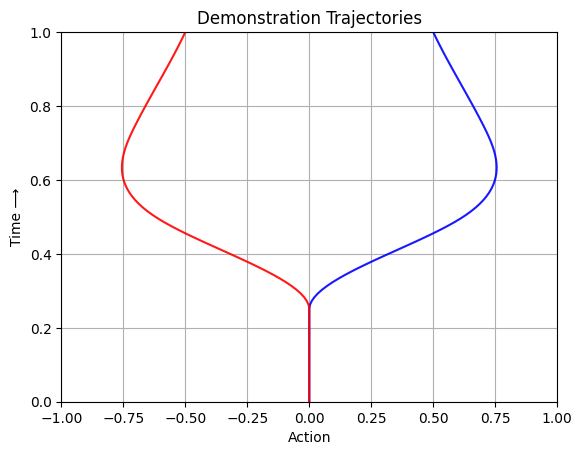

In [4]:
"""
Plot demonstration trajectory on x-y plane where x axis is the state in [-1, 1]
and y axis is the time in [0, 1].
"""
times = np.linspace(0, 1, 100)
plt.plot(traj_right.vector_values(times)[0], times, color='blue', alpha=0.9)
plt.plot(traj_left.vector_values(times)[0], times, color='red', alpha=0.9)
plt.xlim(-1, 1)
plt.ylim(0, 1)
plt.xlabel('Action')
plt.ylabel('Time ⟶')
plt.title('Demonstration Trajectories')
plt.grid(True)
plt.show()

## Notation
| Symbol | Space | Meaning |
|:--------:|:-------:|:---------:|
| $t$ | $[0, 1]$ | Time |
| $a$ | $\mathcal{A}$| Action |
| $z$ | $\mathcal{A}$| Latent variable |
| $x = (a, z)$ | $\mathcal{A}^2$ | State |
| $v$ | $T\mathcal{A}^2$ | Velocity |
| $h$ | $\mathcal{H}$  | Observation history |
| $v_\theta(a, z, t \mid h)$ | $T\mathcal{A}^2$ | Learned flow policy |
| $\xi \sim \mathcal{D}$ | $[0, 1] \rightarrow \mathcal{A}$ | Random variable for demonstration trajectories |
| $\xi(t)$ | $\mathcal{A}$ | Action in the demonstration at time $t$ |
| $\dot{\xi}(t)$ | $T\mathcal{A}$ | Velocity in the demonstration at time $t$ |


In this notebook, $x \equiv a$.

## Conditional flow

In [5]:
fp = StreamingFlowPolicyLatentBad(dim=1, trajectories=[traj_right], prior=[1.0], σ0=σ0, σ1=σ1, k=k)

Given $\xi \sim \mathcal{D}$ with associated observation history $o$, we extend the state space using a latent variable $z \in \mathbb{C}$. We define the initial distribution at $t = 0$ as follows.

<p style="text-align:center;"><ins>Initial sample</ins></p>

$$
\begin{align*}
z_0 &\sim \mathcal{N}(0, I) \\
a_0 &\sim \mathcal{N}(\xi(0), \sigma_0^2)
\end{align*}
$$

We use two hyperparameters $\sigma_0$ and $\sigma_1$ to represent how peaked the distribution should be at $t = 0$ and $t = 1$ respectively, where $\sigma_1 \geq \sigma_0$. For convenience, define the "residual standard deviation" $\sigma_r = \sqrt{\sigma_1^2 e^{2k} - \sigma_0^2}$. For an initial sample $(a_0, z_0)$, we define the *flow* trajectory as:

<p style="text-align:center;"><ins>Flow trajectory</ins></p>

$$
\begin{align*}
a(t \mid \xi, a_0, z_0) &= \xi(t) + \left(a_0 - \xi(0) + (\sigma_r t)z_0\right) e^{-kt} \tag{1} \\
z(t \mid \xi, a_0, z_0) &= (1 - (1 - \sigma_1)t)z_0 + t \xi(t) \tag{2}
\end{align*}
$$

The flow is a diffeomorphism from $\mathbb{C}^2$ to $\mathbb{C}^2$ for every $t \in [0, 1]$.

Note that $a(0 \mid \xi, a_0, z_0) = a_0$ and $z(0 \mid \xi, a_0, z_0) = z_0$, so the diffeomorphism is identity at $t=0$.
The marginal distribution at $t=1$ for $a$ and $z$ is given by $a(t \mid \xi) \sim \mathcal{N}(\xi(1), \sigma_1^2)$ and $z(t \mid \xi) \sim \mathcal{N}(\xi(1), \sigma_1^2)$.

Since $(a, z)$ at time $t$ is a linear transformation of $(a_0, z_0)$, the joint distribution of $(a, z)$ at every timestep is a Gaussian given by:

<p style="text-align:center;"><ins>Joint distribution of (a, z) at each timestep</ins></p>

$$
\begin{align*}
\begin{bmatrix}a\\z\end{bmatrix} =& \underbrace{\begin{bmatrix} e^{-kt} & \sigma_r t\,e^{-kt} \\ 0 & 1-(1-\sigma_1)t \end{bmatrix}}_{A}\begin{bmatrix}a_0\\z_0\end{bmatrix} + \underbrace{\begin{bmatrix}\xi(t) - \xi(0)e^{-kt}\\ t\xi{t}\end{bmatrix}}_b\\
p(a, z \mid \xi, t) =& ~\mathcal{N} \left( A \mu_0 + b \,,\, A \Sigma_0 A^T\right)\\
=& ~\mathcal{N} \left( \begin{bmatrix}\phantom{t}\xi(t)\\ t\xi(t) \end{bmatrix}, \begin{bmatrix} \Sigma_{11} & \Sigma_{12} \\ \Sigma_{12} & \Sigma_{22}\end{bmatrix}\right) \text{ where}\\
&~~\Sigma_{11} = \left(\sigma_0^2 + \sigma_r^2 t^2\right)e^{-2kt}\\
&~~\Sigma_{12} = \sigma_r t\,e^{-kt}\left(1 - (1-\sigma_1)t\right)\\
&~~\Sigma_{22} = \left(1 - (1-\sigma_1)t\right)^2
\end{align*}
$$

Note that $\mu_0 = \begin{bmatrix}\xi(0)\\0 \end{bmatrix}$ and $\Sigma_0 = \begin{bmatrix} \sigma_0^2 & 0 \\ 0 & 1\end{bmatrix}$.

At time $t$, the velocity of the trajectory starting from $(a_0, z_0)$ is:

$$
\begin{align*}
\dot{a}(t \mid \xi, a_0, z_0) &= \dot{\xi}(t) - k\left(a_0 - \xi(0) + (\sigma_r t)z_0\right) e^{-kt} + \sigma_r z_0 e^{-kt}\tag{3} \\
\dot{z}(t \mid \xi, a_0, z_0) &= \xi(t) + t \dot{\xi}(t) - (1 - \sigma_1)z_0 \tag{4}
\end{align*}
$$

The flow induces a velocity field at every $(a, z, t)$. The conditional velocity field $v_\theta(a, z, t \mid h)$ by first inverting the flow transformation in Eq (1, 2), and plugging that into Eq. (3, 4):

- First, given $a = a(t \mid \xi, a_0, z_0)$ and $z = z(t \mid \xi, a_0, z_0)$, invert the flow to compute $a_0$ and $z_0$.

$$
\begin{align*}
z_0 &= \frac{z - t \xi(t)}{1 - (1 - \sigma_1)t} \\
a_0 &= \xi(0) + \left(a - \xi(t)\right)e^{kt} - (\sigma_r t) z_0
\end{align*}
$$

- Then, plug this into Eq. (3, 4) to compute the conditional velocity field:

<p style="text-align:center;"><ins>Conditional velocity field</ins></p>

$$
\begin{align*}
v_a(a, z, t \mid \xi) &= \dot{\xi}(t) - k\left( a - \xi(t) \right)+  \frac{\sigma_r \, e^{-kt}}{1 - (1 - \sigma_1)t}\left(z - t \xi(t)\right) \tag{5} \\
v_z(a, z, t \mid \xi) &= \xi(t) + t \dot{\xi}(t) - \frac{1 - \sigma_1}{1 - (1 - \sigma_1)t} \left(z - t \xi(t)\right) \tag{6}
\end{align*}
$$

## Plot conditional probability path of right trajectory

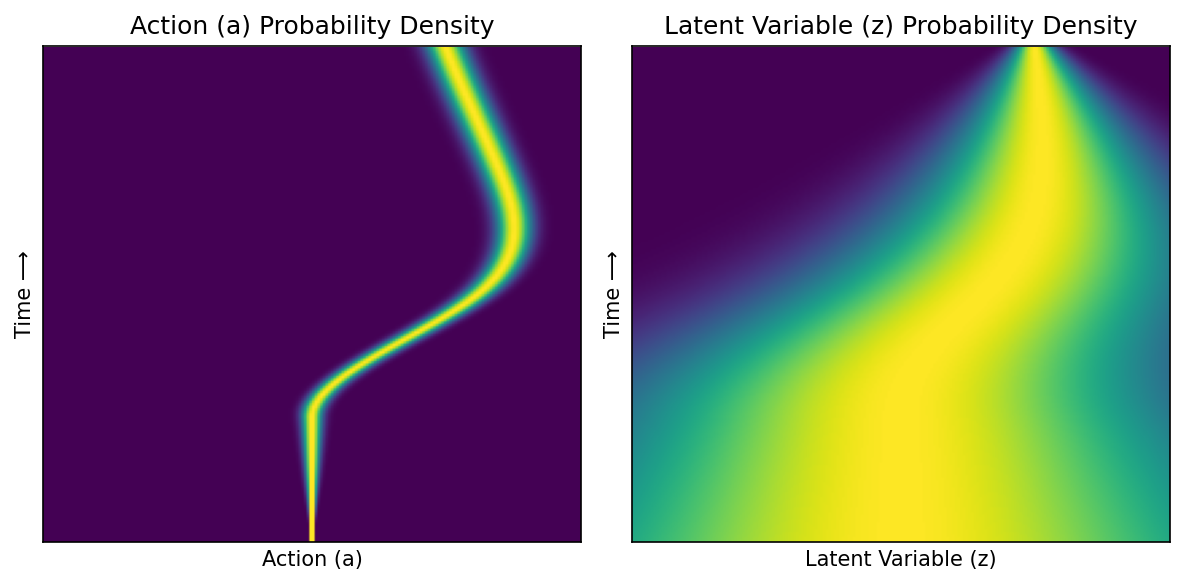

In [6]:
fig = plt.figure(figsize=(8, 4), dpi=150)

xs = torch.linspace(-1, 1, 200)
ts = torch.linspace(0, 1, 200)
ts, xs = torch.meshgrid(ts, xs, indexing='ij')  # (T, X)

gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

plot_probability_density_a(fp, ts, xs, ax1)
plot_probability_density_z(fp, ts, xs, ax2)

ax1.set_title('Action (a) Probability Density', size='large')
ax2.set_title('Latent Variable (z) Probability Density', size='large')

ax1.set_xlabel('Action (a)')
ax1.set_ylabel('Time ⟶')
ax2.set_xlabel('Latent Variable (z)')
ax2.set_ylabel('Time ⟶')

plt.tight_layout()
plt.show()

## Plot conditional velocity field of right trajectory, taking expectation over other variable 

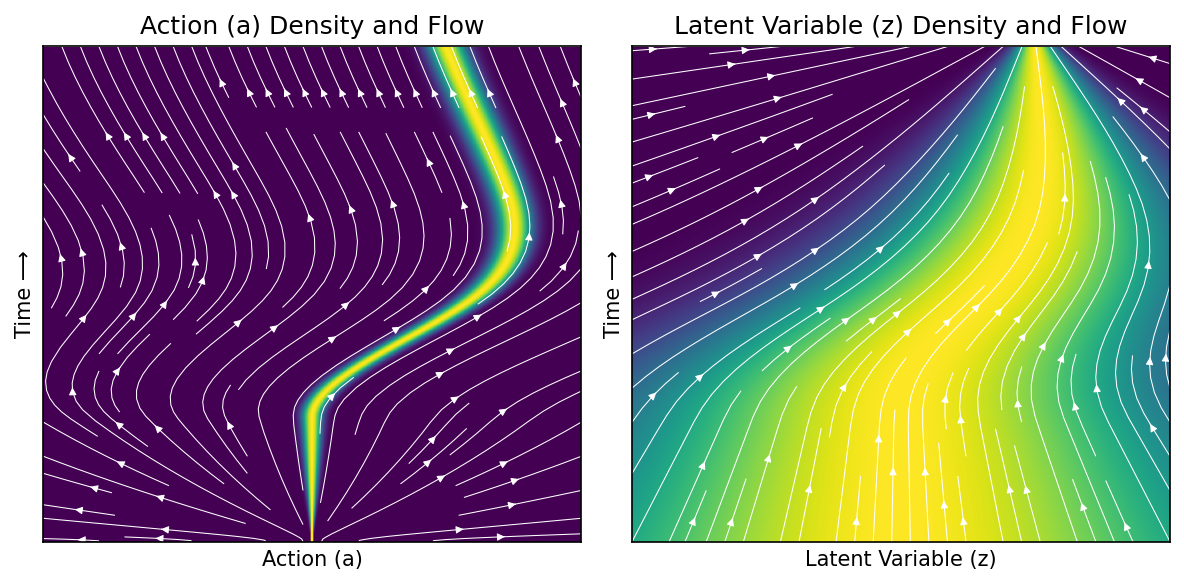

In [7]:
fig = plt.figure(figsize=(8, 4), dpi=150)

xs = torch.linspace(-1, 1, 200)
ts = torch.linspace(0, 1, 200)
ts, xs = torch.meshgrid(ts, xs, indexing='ij')  # (T, X)

gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

plot_probability_density_and_streamlines_a(fp, ax1)
plot_probability_density_and_streamlines_z(fp, ax2)

ax1.set_title('Action (a) Density and Flow', size='large')
ax2.set_title('Latent Variable (z) Density and Flow', size='large')

ax1.set_xlabel('Action (a)')
ax1.set_ylabel('Time ⟶')
ax2.set_xlabel('Latent Variable (z)')
ax2.set_ylabel('Time ⟶')

plt.tight_layout()
plt.show()

## Plot trajectories under conditional flow of right trajectory

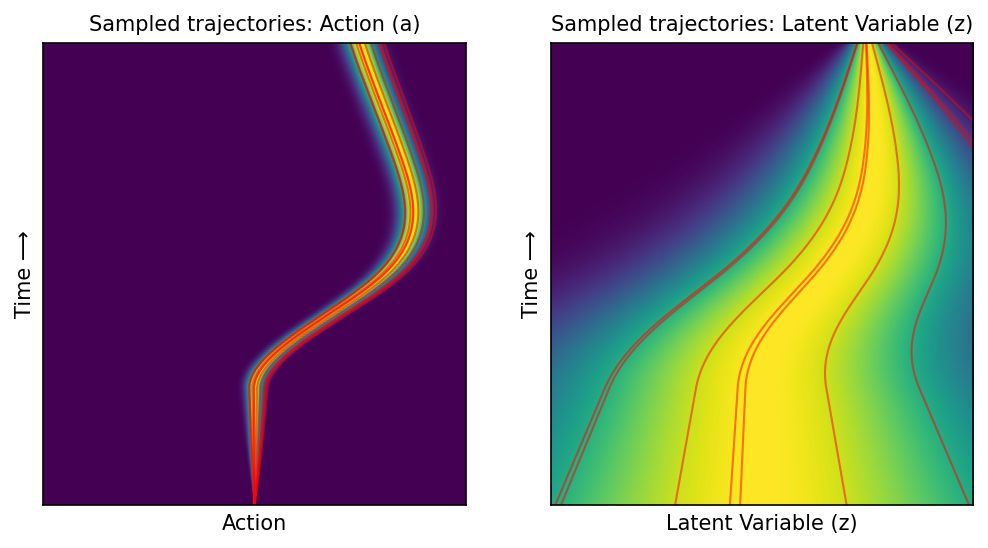

In [8]:
a_starts = [0.0] * 10
z_starts_pos = np.abs(np.random.randn(5))
z_starts_neg = -np.abs(np.random.randn(5))
z_starts = sorted(np.concatenate([z_starts_neg, z_starts_pos]))
colors = ['red'] * 5 + ['red'] * 5

fig = plt.figure(figsize=(8, 4), dpi=150)

gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

plot_probability_density_with_static_trajectories(
    fp, ax1, ax2, a_starts, z_starts, colors, num_points_x=400,
)
plt.show()


## Marginal flow

In [9]:
fp = StreamingFlowPolicyLatentBad(dim=1, trajectories=[traj_right, traj_left], prior=[0.5, 0.5], σ0=σ0, σ1=σ1, k=k)

## Training

Flow matching loss:

$$
\mathcal{L}_\mathrm{FM}(\theta, \mathcal{D}) = \mathbb{E}_{\xi \sim \mathcal{D},\ t,\ x \sim x(t \mid \xi)} \big\| v_\theta(a, z, t \mid h) - v(a, z, t \mid \xi) \big\|_2^2
$$

1. Sample trajectory from dataset $\xi \sim \mathcal{D}$.
2. Sample $a_0 \sim \mathcal{N}(\xi(0), \sigma_0^2)$.
3. Sample $z_0 \sim \mathcal{N}(0, I)$.
4. Sample $t \sim \text{Uniform}([0, 1])$.
5. Compute $a = a(t \mid \xi, a_0, z_0)$ and $z = z(t \mid \xi, a_0, z_0)$ using Eq. (1, 2).
6. Compute conditional velocity field $v_\theta(a, z, t \mid h)$ using Eq. (5, 6).
6. Compute L2 loss: $\| v_\theta(a, z, t \mid h) - v(a, z, t \mid \xi) \|_2^2$.


## Flow matching theorem

If $v^*(x, t \mid h)$ is the optimal velocity field that minimizes the flow matching loss, then the marginal distributions $\mathbb{P}^*(x \mid t, h)$ induced by $v^*$ at *every* time $t$ is the "average" of the conditional flow distributions $\mathbb{P}(x \mid t, \xi)$ averaged over the training distribution.

$$
\mathbb{P}^*(x \mid t, h) = \mathbb{E}_{\xi} \left[ \mathbb{P}(x \mid t, \xi) \right], \ \forall x \in \mathbb{C}^2, \forall t \in [0, 1]
$$

where here, $x = (a, z)$.

## Plot marginal probability path

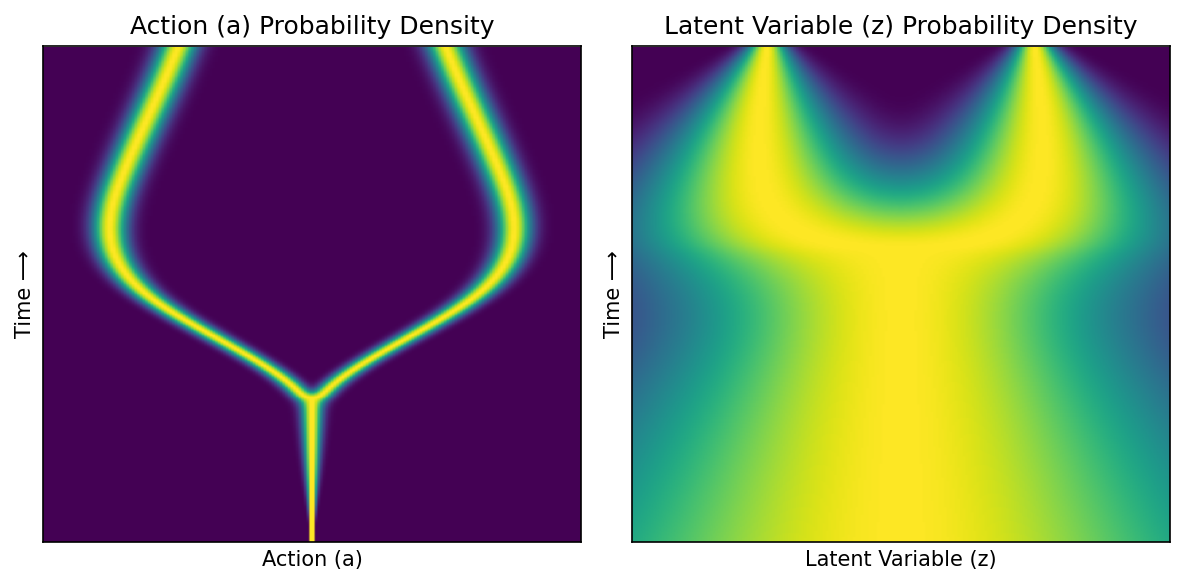

In [10]:
fig = plt.figure(figsize=(8, 4), dpi=150)

xs = torch.linspace(-1, 1, 200)  # (X,)
ts = torch.linspace(0, 1, 400)  # (T,)
ts, xs = torch.meshgrid(ts, xs, indexing='ij')  # (T, X)

gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

plot_probability_density_a(fp, ts, xs, ax1)
plot_probability_density_z(fp, ts, xs, ax2)

ax1.set_title('Action (a) Probability Density', size='large')
ax2.set_title('Latent Variable (z) Probability Density', size='large')

ax1.set_xlabel('Action (a)')
ax1.set_ylabel('Time ⟶')
ax2.set_xlabel('Latent Variable (z)')
ax2.set_ylabel('Time ⟶')

plt.tight_layout()
plt.show()

## Plot marginal velocity field, taking expectation over other variable 

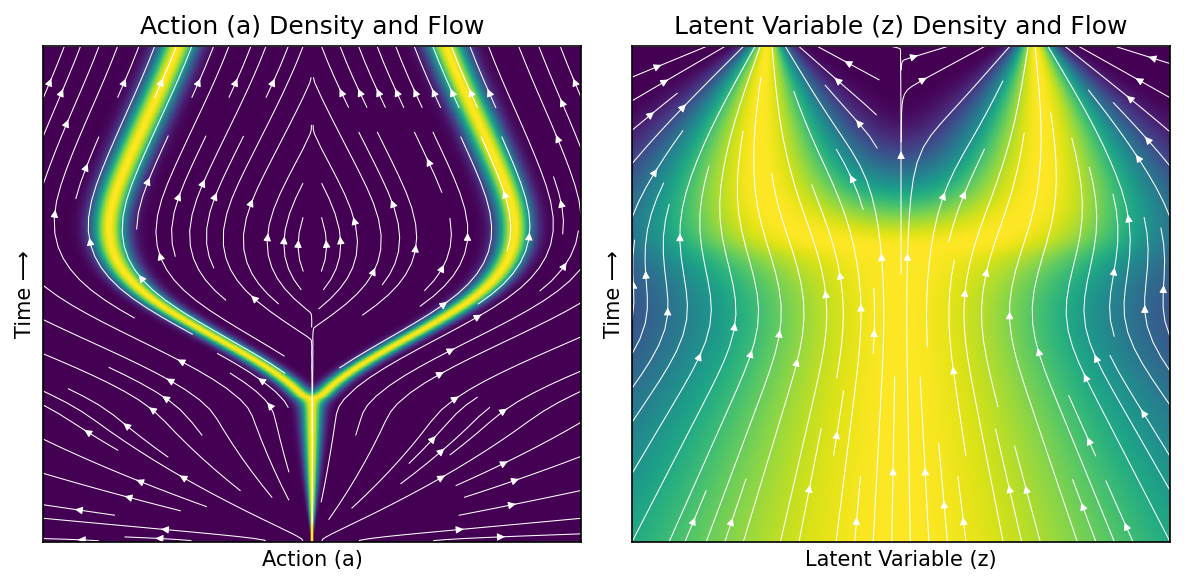

In [11]:
fig = plt.figure(figsize=(8, 4), dpi=150)

xs = torch.linspace(-1, 1, 200)
ts = torch.linspace(0, 1, 200)
ts, xs = torch.meshgrid(ts, xs, indexing='ij')  # (T, X)

gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

plot_probability_density_and_streamlines_a(fp, ax1)
plot_probability_density_and_streamlines_z(fp, ax2)

ax1.set_title('Action (a) Density and Flow', size='large')
ax2.set_title('Latent Variable (z) Density and Flow', size='large')

ax1.set_xlabel('Action (a)')
ax1.set_ylabel('Time ⟶')
ax2.set_xlabel('Latent Variable (z)')
ax2.set_ylabel('Time ⟶')

plt.tight_layout()
plt.show()

## Plot trajectories under marginal flow

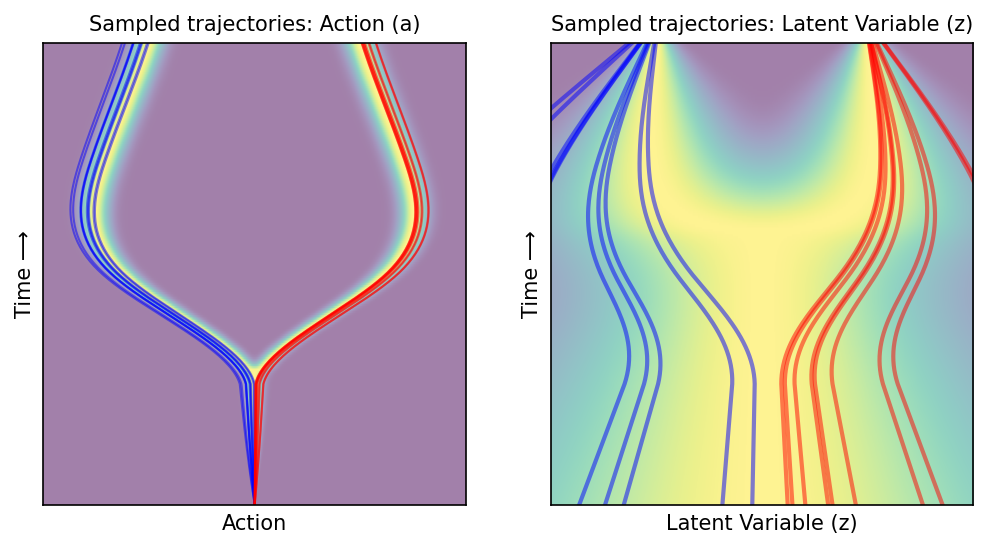

In [12]:
a_starts = [0.0] * 20
z_starts_pos = np.abs(np.random.randn(10))
z_starts_neg = -np.abs(np.random.randn(10))
z_starts = sorted(np.concatenate([z_starts_pos, z_starts_neg]))
colors = ['blue'] * 10 + ['red'] * 10

fig = plt.figure(figsize=(8, 4), dpi=150)

gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

plot_probability_density_with_static_trajectories(
    fp, ax1, ax2, a_starts, z_starts, colors,
    heatmap_alpha=0.5,
    linewidth_a=1, linewidth_z=2,
    num_points_x=400,
)
plt.show()